In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import gensim
import plotly.graph_objects as go
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load dataset**

In [48]:
# Load train data
train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "latin1")

# Load test data
test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "latin1")

**Convert text labels to integer labels**

In [49]:
i = 0
for res in set(df["Sentiment"].values):
  df['Sentiment'][df['Sentiment'] == res] = i
  i = i + 1

**Pre-Processing**

In [50]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet of Train set
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : remove_url(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : remove_emoji(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : decontraction(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : char(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : x.lower())

# Apply functions on OriginalTweet of Test set
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : remove_url(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : remove_emoji(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : decontraction(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : char(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : x.lower())

**Plot distribution of the classes in train set and test set**

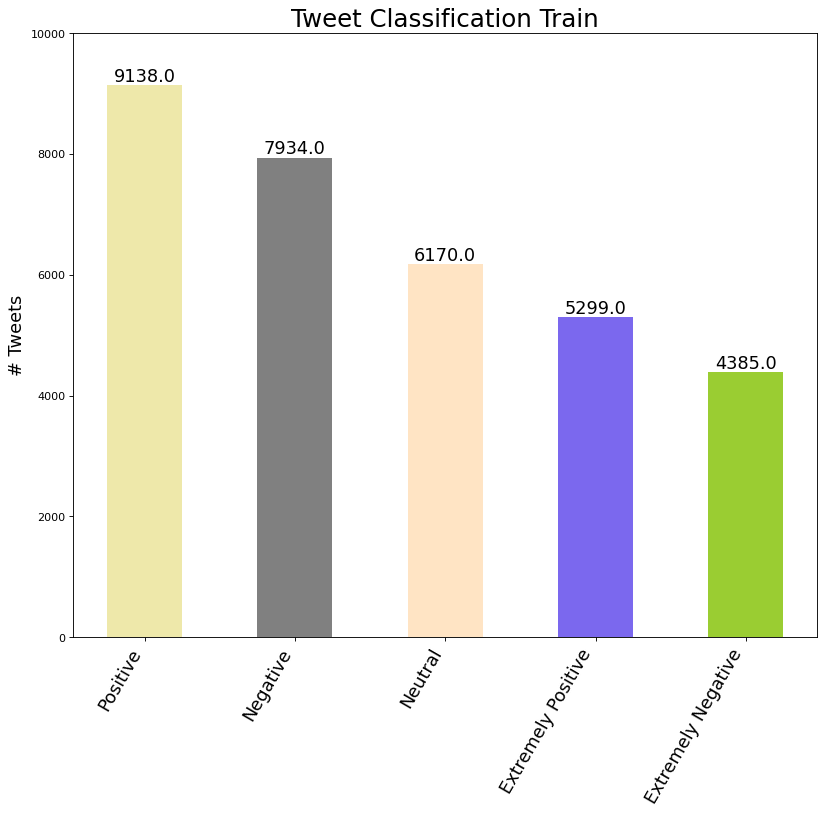

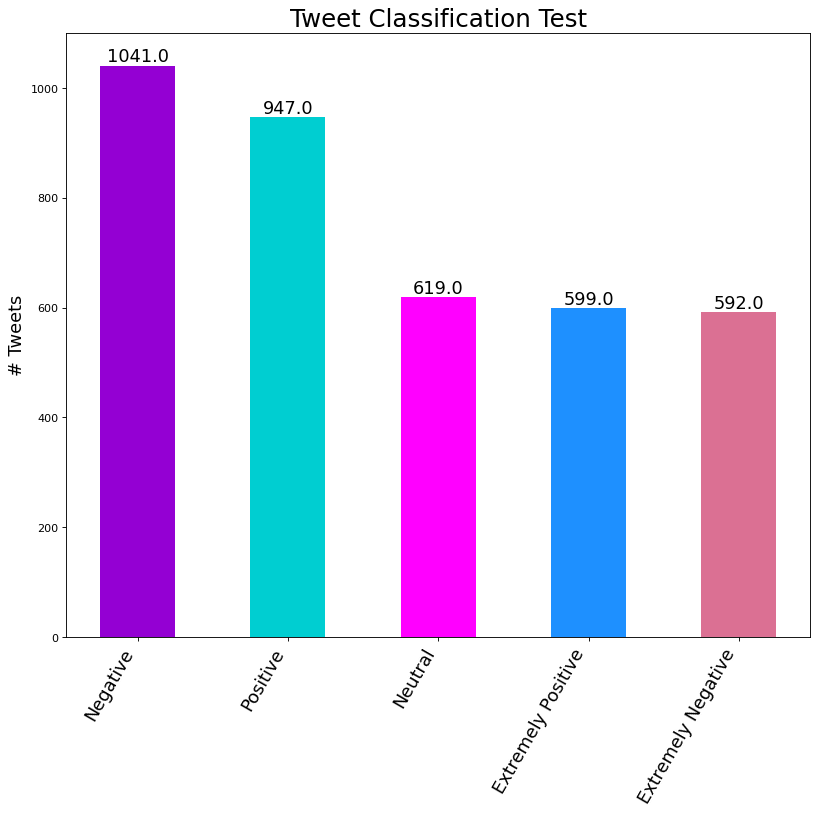

In [43]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 10000)
plot_class_dist(num_label_test.index, num_label_test.values, "Tweet Classification Test", 1100)

**Plot number of words in the tweets**

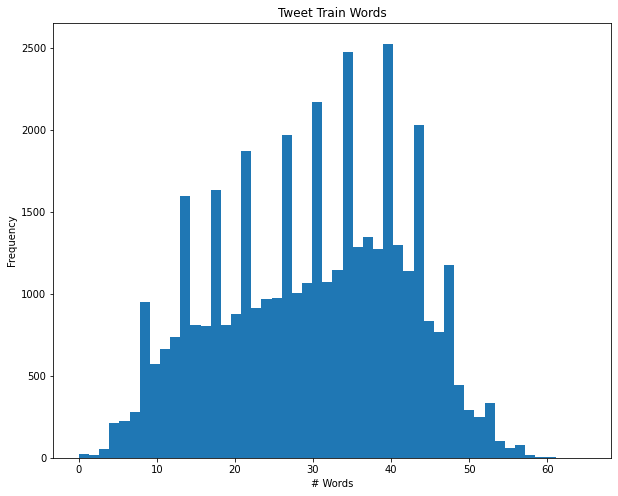

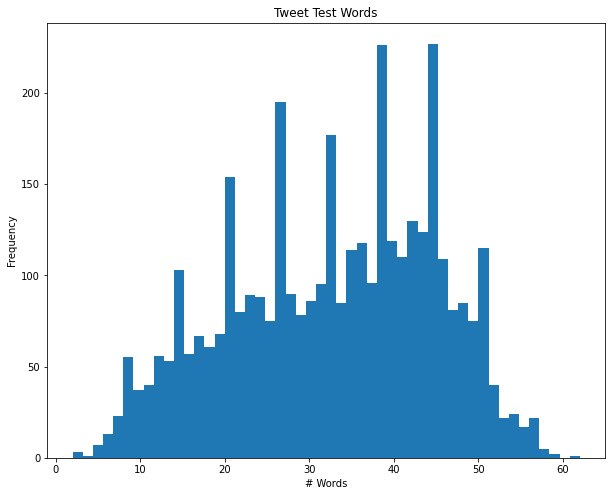

In [45]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()

test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()

**Create Vocabulary**

In [51]:
# Dataset word2vec model
w2v = Word2Vec(train['OriginalTweet'].tolist())
print(w2v)

# List the vocabulary words
words = list(w2v.wv.vocab)
print(words)
# Show the dictionary of vocab words
w2v.wv.vocab

'''
X = w2v[w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Create a scatter plot of the projection

plt.scatter(result[:, 0], result[:, 1])
words = list(w2v.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()
'''


Word2Vec(vocab=27, size=100, alpha=0.025)
['m', 'e', 'n', 'y', 'r', 'b', 'i', ' ', 'p', 'h', 'l', 'g', 'a', 'c', 's', 't', 'v', 'd', 'k', 'o', 'u', 'f', 'x', 'w', 'q', 'z', 'j']


'\nX = w2v[w2v.wv.vocab]\npca = PCA(n_components=2)\nresult = pca.fit_transform(X)\n\n# Create a scatter plot of the projection\n\nplt.scatter(result[:, 0], result[:, 1])\nwords = list(w2v.wv.vocab)\nfor i, word in enumerate(words):\n    plt.annotate(word, xy=(result[i, 0], result[i, 1]))\n\nplt.show()\n'

In [52]:
def getEmbedding(list_words, w2v_model):
  word_set = set(w2v_model.wv.index2word)
  X = np.zeros([len(list_words), 100])
  c = 0
  for words in list_words:
      for w in words:
          if w in word_set:
              X[c] = w2v_model[w]
      c=c+1
  return X

**Baseline**

In [54]:
x_train = getEmbedding(train["OriginalTweet"].tolist(), w2v)
x_test = getEmbedding(test["OriginalTweet"].tolist(), w2v)
x_val = getEmbedding(validation["OriginalTweet"].tolist(), w2v)

In [55]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, train["Sentiment"].values).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))

Number of mislabeled points out of a total 3798 points : 3112


In [ ]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

KeyboardInterrupt: ignored

In [ ]:
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

Number of mislabeled points out of a total 3796 points : 2830


In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

Number of mislabeled points out of a total 3796 points : 2847


0.25

**New Network**

In [34]:
X = train['OriginalTweet']
y = train['Sentiment']

# Split data into train , test
X_train , X_val , y_train , y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_test = test['OriginalTweet']
y_test = test['Sentiment']

# Convert y to categorical 
y_train = to_categorical(y_train, 5)
y_test  = to_categorical(y_test, 5)
y_val  = to_categorical(y_test, 5)

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

# convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val_final = pad_sequences(list_tokenized_val, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

47810


In [36]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary, 300, input_length=100, trainable=True)) 

#lstm layer
model.add(LSTM(128, return_sequences=True, dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(5,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#Print summary of model
print(model.summary())

history = model.fit(X_train_final, y_train, epochs=2, validation_data=(X_val_final, y_val))

_,test_acc = model.evaluate(X_test_final, y_test)
print(test_acc)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 300)          14343000  
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total params: 14,571,229
Trainable params: 14,571,229
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1124/1124 [==============================] - 64s 55ms/step - loss: 0.3630 - acc: 0.5546 - va

In [ ]:
def create_dataset(xs, ys, n_classes=10):
  ys = tf.one_hot(ys, depth=n_classes)
  return tf.data.Dataset.from_tensor_slices((xs, ys)) \
    .map(preprocess) \
    .shuffle(len(ys)) \
    .batch(128)

train_dataset = create_dataset(x_train, y_train, 5)
val_dataset = create_dataset(x_val, y_val, 5)

In [ ]:
model = keras.Sequential([                     
    keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(x_train[], 28)),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=192, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])